In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklean imports 
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import *

In [2]:
# Set colour palette 

greys = ['#767676', '#b3b3b3', '#212121']
sns.set_palette(sns.color_palette(greys))


# Data import and cleaning 

In [3]:
# Data import
df_raw = pd.read_csv('48_Industry_Portfolios_Daily.csv', skiprows=range(0,9))
df_raw.drop(axis=0, labels=range(25292,len(df_raw)), inplace=True)

C:\Users\seanl\AppData\Local\Temp\ipykernel_8120\4267491402.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('48_Industry_Portfolios_Daily.csv', skiprows=range(0,9))


In [4]:
# Data cleaning 
df = df_raw.copy()
df = df.apply(pd.to_numeric)
df.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

tmp = df.columns
tmp = list(tmp)

#--------------------------------------------------------------------------------------------------
# Column headers have random spaces, so i removed them 
out = []
for i in tmp:
    out.append(i.replace(' ', ''))

df.columns = out

# Changing date to actual date format 
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].apply(lambda x: (x[:4] + '-' + x[4:6] + '-' + x[6:]))
df['Date'] = pd.to_datetime(df['Date'])

df.head()
#df.info()

,Date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1926-07-01,0.56,-0.07,-99.99,-1.39,0.00,-1.44,0.62,-1.27,-0.90,...,-0.93,0.14,2.77,-0.02,0.27,0.59,0.47,0.81,0.57,-1.66
1,1926-07-02,0.29,0.06,-99.99,0.78,0.70,1.46,0.03,0.00,-0.34,...,1.07,0.07,0.00,0.01,-0.10,1.04,-0.03,-0.61,-1.03,3.09
2,1926-07-06,-0.33,0.18,-99.99,-1.74,0.50,-0.96,-0.06,4.27,-1.20,...,0.73,-0.20,0.77,-0.22,-0.67,0.45,0.31,-0.72,0.62,1.41
3,1926-07-07,3.57,-0.15,-99.99,-1.73,-0.12,-0.49,-0.06,-4.10,-0.22,...,2.22,0.18,-3.21,-0.57,-1.08,-1.09,0.21,0.07,0.17,0.62
4,1926-07-08,0.30,1.12,-99.99,-0.15,0.30,-0.49,0.24,0.00,-0.01,...,-0.39,0.46,-1.10,-0.38,0.33,0.99,-0.88,-0.36,-1.10,0.98


# Trying to get the correct min var portfolio 

In [5]:
# Selecting only the most recent 63 days 
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

temp = df.copy()
temp = temp.iloc[date_i-no_obj:date_i,:]
temp.shape

(63, 49)

In [6]:
# FOR TESTING 
temp = temp[['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys']]
temp.head()

,Agric,Food,Soda,Beer,Smoke,Toys
25085,-2.01,0.10,-0.39,-0.35,0.57,-3.49
25086,1.91,0.75,0.51,0.36,-0.13,1.07
25087,-2.85,1.00,1.03,1.84,0.38,1.78
25088,1.04,-0.07,0.36,1.08,-0.63,2.05
25089,0.48,-0.48,0.09,-0.01,0.00,-1.04


In [7]:
# Use the first 63 as training data
R_train = temp
sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

In [8]:
arr_len = 6

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)

'''
print('Equal weight portfolio: {}'.format(eq_w))
print('\n')
print('y_train: {}'.format(y_train))
'''

"\nprint('Equal weight portfolio: {}'.format(eq_w))\nprint('\n')\nprint('y_train: {}'.format(y_train))\n"

In [9]:
# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

print(R_train.shape, N.shape)

# Calculate X
X_train = np.dot(R_train, N)

'''
print('N matrix: {}'.format(N))
print('\n')
print('X_train: {}'.format(X_train))
'''

(63, 6) (6, 5)


"\nprint('N matrix: {}'.format(N))\nprint('\n')\nprint('X_train: {}'.format(X_train))\n"

In [10]:
# Linear regression to get min var portfolio
reg = LinearRegression(fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w = eq_w - np.dot(N,beta)

#--------------------------------------------------------------------------------------------------

'''
test_r2 = reg.score(X_test, y_test)
test_mse = mean_squared_error(y_test, ridge.predict(X_test))
'''

print(f'train_r2: {train_r2}')
print(f'train_mse: {train_mse}')
print('\n')

print(f'beta: {beta}')
print(f'w            : {[round(num, 3) for num in w]}')
print(f'Actual values: {str([-.002, -.004, .049, .514, .316, .128])}')

'''
print(test_r2)
print(test_mse)
'''

train_r2: 0.22247593212981887
train_mse: 0.46020583341227367


beta: [ 0.16927953  0.16834143  0.11724264 -0.34557298 -0.14832212]
w            : [-0.003, -0.002, 0.049, 0.512, 0.315, 0.128]
Actual values: [-0.002, -0.004, 0.049, 0.514, 0.316, 0.128]


'\nprint(test_r2)\nprint(test_mse)\n'

# Q1. 

### Model fit scatter plot (to explain overfitting) [CAN USE]

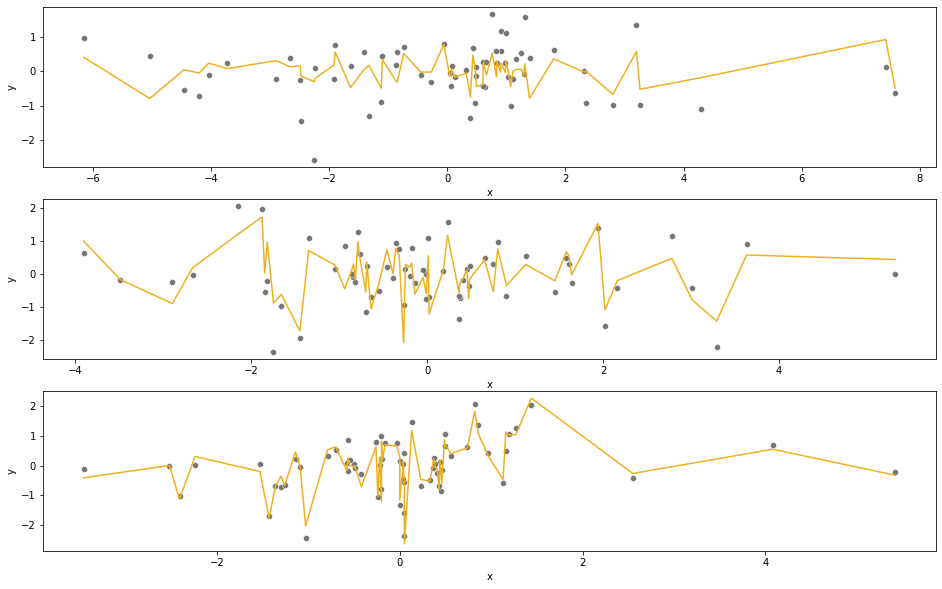

In [11]:
covariates = [6, 24, 48]
fig, axs = plt.subplots(nrows=3, figsize=(16,10))
counter = 0


for cov_num in covariates:
    # This is all code to get the data into dataframe
    # Selecting the columns 
    temp = df.copy()
    temp = temp.iloc[:,1: cov_num+1]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = temp.iloc[date_i-63:date_i,:]
    
    R_train = R_train.copy()
    sc = StandardScaler(with_std = False)
    R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])
    

    #-------------------------------------------------------------------------------------------
    # Processing
    arr_len = cov_num
    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_temp = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)
    
    # Calculate X
    X_temp = np.dot(R_train, N)

    #-------------------------------------------------------------------------------------------
    temp_df = pd.DataFrame(X_temp)
    temp_df.columns = ['X' + str(i) for i in temp_df.columns]
    temp_df.insert(1, 'y', y_temp)
    temp_df = temp_df.rename({'X0':'x'}, axis=1)
    
    ols = LinearRegression()
    features = temp_df.drop('y', axis = 1)
    target = temp_df['y']
    ols.fit(features, target)
    preds = ols.predict(features)
    sns.scatterplot(x = temp_df.x, y = temp_df.y, color='#767676', ax=axs[counter])
    sns.lineplot(x = temp_df.x, y = preds, color='#edb021', ax=axs[counter])
    
    
    counter += 1

    
    
plt.show()


### Relationship between -log(alpha) and MSE

In [12]:
# Selecting the columns 
q1 = df.copy()
q1 = q1[['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']]
q1.head()

,Trans,Hshld,Guns,LabEq,Fin,Hlth
0,0.14,-0.90,-99.99,0.00,0.57,-99.99
1,0.07,-0.34,-99.99,1.80,-1.03,-99.99
2,-0.20,-1.20,-99.99,0.66,0.62,-99.99
3,0.18,-0.22,-99.99,-0.66,0.17,-99.99
4,0.46,-0.01,-99.99,0.33,-1.10,-99.99


In [13]:
# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = q1.iloc[date_i-no_obj:date_i,:]

R_train = R_train.copy()
sc = StandardScaler(with_std = False)
R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])

R_train.shape

(63, 6)

In [14]:
# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(63 / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = q1.iloc[date_i:date_i+no_obj,:]

R_test = R_test.copy()
sc = StandardScaler(with_std = False)
R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])

R_test.shape

(27, 6)

### Ridge

In [15]:
arr_len = 6

# y values
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)
y_test = np.dot(R_test, eq_w)

#--------------------------------------------------------------------------------------------------

# X values
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

X_train = np.dot(R_train, N)
X_test = np.dot(R_test, N)

'''
print('y_train: {}'.format(y_train))
print('y_test: {}'.format(y_test))
print('\n')
print('X_train: {}'.format(X_train))
print('X_test: {}'.format(X_test))
'''

"\nprint('y_train: {}'.format(y_train))\nprint('y_test: {}'.format(y_test))\nprint('\n')\nprint('X_train: {}'.format(X_train))\nprint('X_test: {}'.format(X_test))\n"

In [16]:
alpha_vec = np.logspace(-10,3,100)

# results list 
train_r2 = []
train_mse = []
coeff_dict = {}

test_r2 = []
test_mse = []

for cur_alpha in alpha_vec:
    ridge = Ridge(cur_alpha)
    ridge.fit(X_train, y_train)
    
    # Training
    train_r2.append(ridge.score(X_train, y_train))
    train_mse.append(mean_squared_error(y_train, ridge.predict(X_train)))
    coeff_dict[cur_alpha] = ridge.coef_
    
    # Test 
    test_r2.append(ridge.score(X_test, y_test))
    test_mse.append(mean_squared_error(y_test, ridge.predict(X_test)))
    


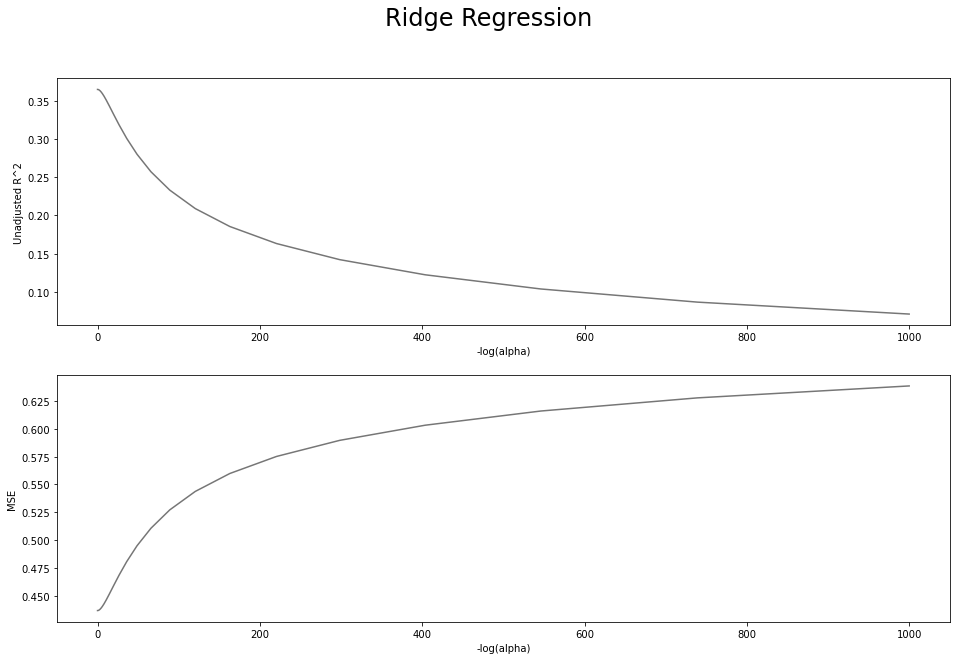

In [17]:
# r2 and mse plots for training 
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
sns.lineplot(x=alpha_vec, y=np.array(train_r2), ax=axs[0])
axs[0].set(xlabel='-log(alpha)', ylabel='Unadjusted R^2')

sns.lineplot(x=alpha_vec, y=np.array(train_mse), ax=axs[1])
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

fig.suptitle('Ridge Regression', fontsize = 24)

plt.show()

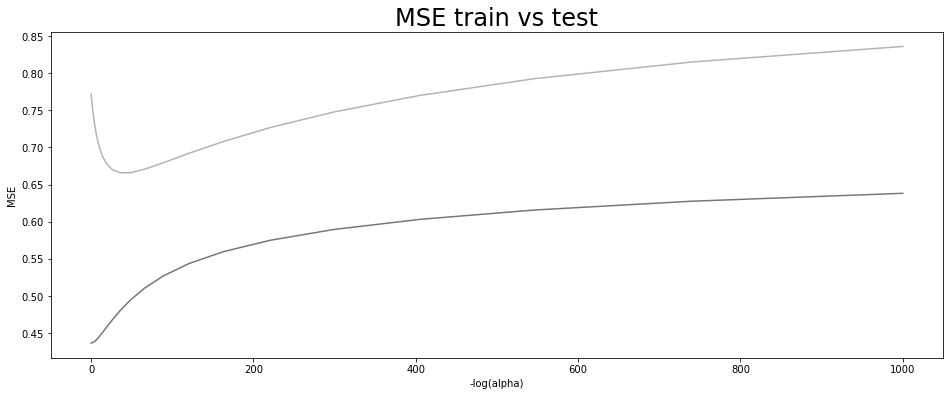

In [18]:
# mse plots for training vs test 
plt.figure(figsize=(16,6))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(train_mse))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(test_mse))
fig1.set(xlabel='-log(alpha)', ylabel='MSE')
plt.title('MSE train vs test', fontsize = 24)

plt.show()

### Lasso

In [19]:
alpha_vec = np.logspace(-10,0,100)

# results list 
train_r2 = []
train_mse = []
coeff_dict = {}

test_r2 = []
test_mse = []


# iterate over all alphas in range
for cur_alpha in alpha_vec:
    lasso = Lasso(cur_alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    # Training
    train_r2.append(lasso.score(X_train, y_train))
    train_mse.append(mean_squared_error(y_train, lasso.predict(X_train)))
    coeff_dict[cur_alpha] = ridge.coef_
    
    # Test 
    test_r2.append(lasso.score(X_test, y_test))
    test_mse.append(mean_squared_error(y_test, lasso.predict(X_test)))

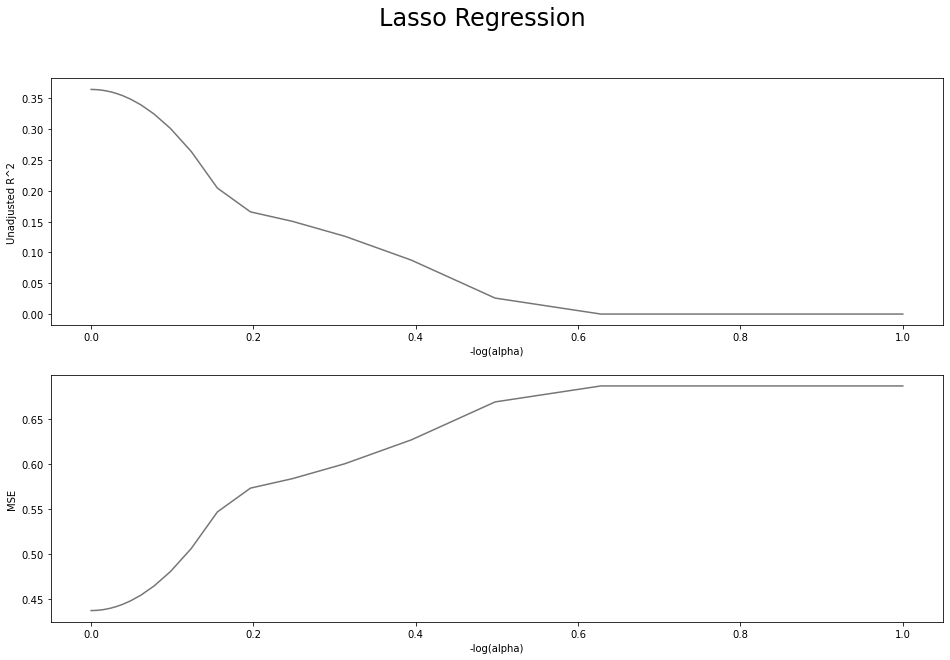

In [20]:
# r2 and mse plots for training 
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
sns.lineplot(x=alpha_vec, y=np.array(train_r2), ax=axs[0])
axs[0].set(xlabel='-log(alpha)', ylabel='Unadjusted R^2')

sns.lineplot(x=alpha_vec, y=np.array(train_mse), ax=axs[1])
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

fig.suptitle('Lasso Regression', fontsize = 24)

plt.show()

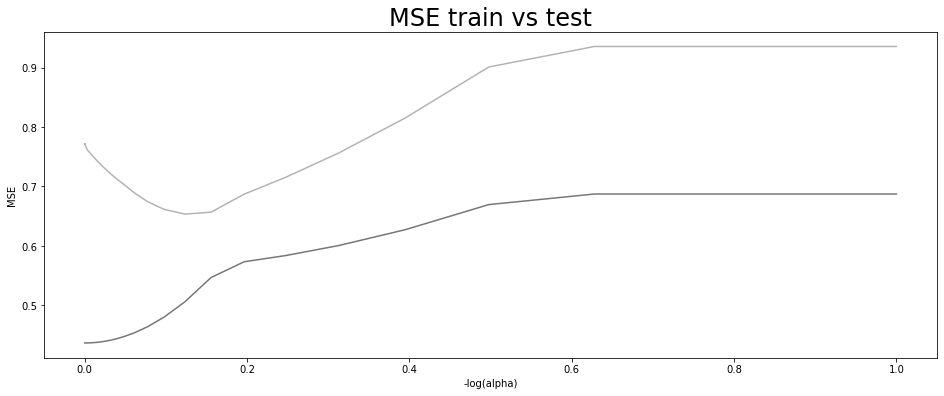

In [21]:
# mse plots for training vs test 
plt.figure(figsize=(16,6))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(train_mse))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(test_mse))
fig1.set(xlabel='-log(alpha)', ylabel='MSE')
plt.title('MSE train vs test', fontsize = 24)

plt.show()

### GridsearchCV 

In [22]:
def test(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[X], 
                                                                data[Y], 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [23]:
# Creating the dataset for cross validation 

temp = df.copy()
temp = temp.iloc[:,1: cov_num+1]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = temp.iloc[date_i-63:date_i,:]

# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(no_obj / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = temp.iloc[date_i:date_i+no_obj,:]

#-------------------------------------------------------------------------------------------
# Processing
arr_len = temp.shape[1]

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)
y_train_raw = np.dot(R_train, eq_w)
y_test_raw = np.dot(R_test, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_train_raw = np.dot(R_train, N)
X_test_raw = np.dot(R_test, N)

#-------------------------------------------------------------------------------------------
temp_df_raw = pd.DataFrame(X_train_raw)
temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
temp_df_raw.insert(1, 'y', y_train_raw)
temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

In [24]:
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge(),}

X = ['x']
X.extend(temp_df_raw.columns[2:])
Y = ['y']


test(models, temp_df_raw)

# This shows the models performance! 

,OLS,Lasso,Ridge
0,0.990948,0.000402,0.956381
1,-20.225256,-0.093374,-0.824562


### Finding the best value of alpha done below!! 

In [25]:

pipe_r = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                         ("ridge", Ridge())])

ridge_params = {'ridge__alpha':np.logspace(-8,3,100)}

grid_r = GridSearchCV(estimator=pipe_r, param_grid=ridge_params, n_jobs=-1,  cv = 8)

grid_r.fit(X_train_raw, y_train_raw)

#--------------------------------------------------------------------------------------------------

pipe_l = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                         ("lasso", Lasso())])

lasso_params = {'lasso__alpha':np.logspace(-8,0,100)}

grid_l = GridSearchCV(estimator=pipe_l, param_grid=lasso_params, n_jobs=-1,  cv = 8)

grid_l.fit(X_train_raw, y_train_raw)

#--------------------------------------------------------------------------------------------------


print(f'Ridge best alpha: {grid_r.best_params_}')
print(f'Ridge best score: {grid_r.best_score_}')

print('\n')

print(f'Lasso best alpha: {grid_l.best_params_}')
print(f'Lasso best score: {grid_l.best_score_}')

Ridge best alpha: {'ridge__alpha': 100.0}
Ridge best score: 0.2142625465078659


Lasso best alpha: {'lasso__alpha': 0.12915496650148853}
Lasso best score: 0.17357426844873278


# Cross Validation 

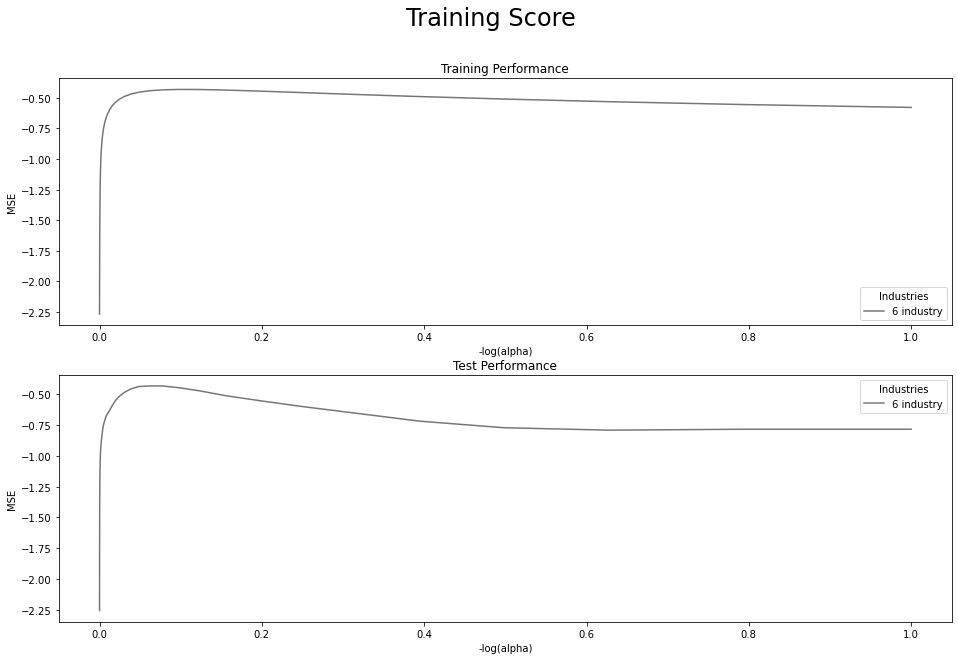

In [26]:

regressions = [Ridge, Lasso]
fig, axs = plt.subplots(nrows=2, figsize=(16,10))

alpha_list = [np.logspace(-8,3,100), np.logspace(-8,0,100)]

counter = 0 

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    cvResults = []
    
    for cur_alpha in alpha_list[counter]:

        clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                 ("mdl", reg(cur_alpha))])

        # Perform 10-fold cross validation 
        scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 8, \
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)

        cvResults.append(scores.mean())
        
    fig = sns.lineplot(y = cvResults, x = alpha_vec, label = "Train Score", ax = axs[counter])
        
    counter += 1

#--------------------------------------------------------------------------------------------------

# Graph
axs[0].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[0].title.set_text('Training Performance')
axs[1].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[1].title.set_text('Test Performance')

axs[0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

plt.suptitle('Training Score', fontsize = 24)
plt.show()

# Q2. 

### Repeat the above procedure for 24 as well as 48 industries

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.149e+00, tolerance: 4.862e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+00, tolerance: 4.862e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.655e-01, toleranc

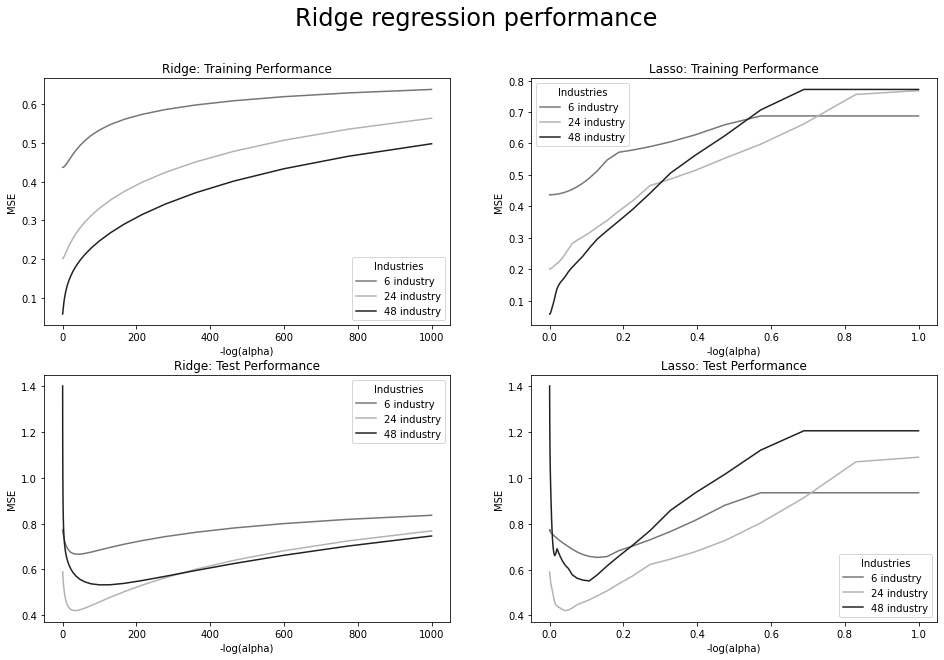

In [27]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]


regressions = [Ridge, Lasso]
alpha_list = [np.logspace(-8,3,100), np.logspace(-8,0,100)]

testing = [ind_6, ind_24, ind_48]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

col = 0

#--------------------------------------------------------------------------------------------------
for reg in regressions:

    for test in testing:
        q2_temp = df.copy()
        q2_temp = q2_temp[test]

        # Selecting training set
        date = '2022-01-03'
        no_obj = 63
        date_i = df[df['Date'] == date].index[0]

        R_train = q2_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        sc = StandardScaler(with_std = False)
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q2_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        sc = StandardScaler(with_std = False)
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])

        '''    
        print(f'Training set shape: {R_train.shape}')
        print(f'Test set shape: {R_test.shape}')
        '''

        arr_len = len(test)

        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train = np.dot(R_train, eq_w)
        y_test = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train = np.dot(R_train, N)
        X_test = np.dot(R_test, N)

        # Model fitting
        alpha_vec = alpha_list[col]

        train_r2_all = []
        train_mse_all = []
        coeff_dict_all = {}

        test_r2_all = []
        test_mse_all = []

        for cur_alpha in alpha_vec:
            mdl = reg(cur_alpha)
            mdl.fit(X_train, y_train)

            # Training
            train_r2_all.append(mdl.score(X_train, y_train))
            train_mse_all.append(mean_squared_error(y_train, mdl.predict(X_train)))
            coeff_dict_all[cur_alpha] = mdl.coef_

            # Test 
            test_r2_all.append(mdl.score(X_test, y_test))
            test_mse_all.append(mean_squared_error(y_test, mdl.predict(X_test)))


        fig = sns.lineplot(x=alpha_vec, y=np.array(train_mse_all), ax=axs[0,col])
        fig = sns.lineplot(x=alpha_vec, y=np.array(test_mse_all), ax=axs[1,col])
    col += 1

#--------------------------------------------------------------------------------------------------
# Graph
axs[0,0].title.set_text('Ridge: Training Performance')
axs[1,0].title.set_text('Ridge: Test Performance')
axs[0,1].title.set_text('Lasso: Training Performance')
axs[1,1].title.set_text('Lasso: Test Performance')

axs[0,0].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[1,0].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[0,1].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[1,1].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])

axs[0,0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1,0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[0,1].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1,1].set(xlabel='-log(alpha)', ylabel='MSE')


plt.suptitle('Ridge regression performance', fontsize = 24)
plt.show()

### Training curves for 6,24 and 48 industries

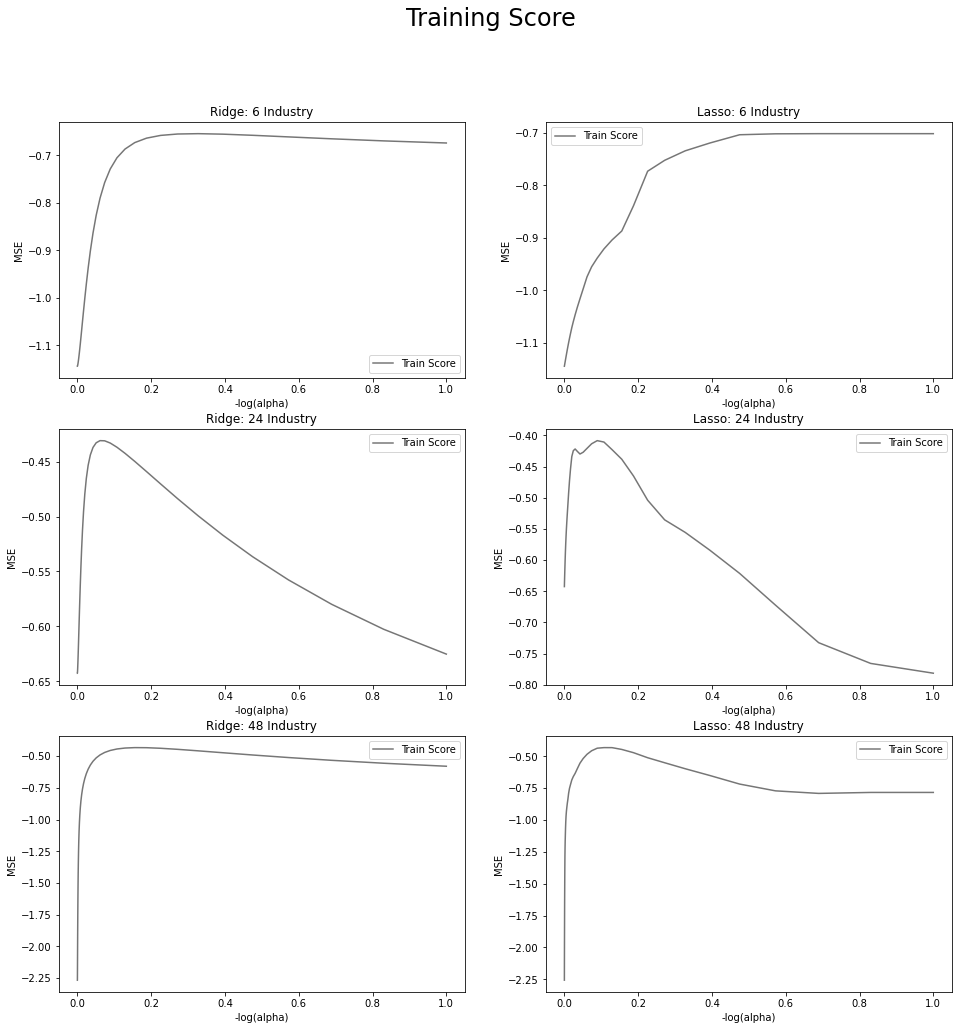

In [28]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

testing = [ind_6, ind_24, ind_48]

#--------------------------------------------------------------------------------------------------

regressions = [Ridge, Lasso]

alpha_list = [np.logspace(-8,3,100), np.logspace(-8,0,100)]
testing = [ind_6, ind_24, ind_48]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
col = 0

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    row = 0
    for test in testing:
        cvResults = []
        
        q2_temp = df.copy()
        q2_temp = q2_temp[test]

        # Selecting training set
        date = '2022-01-03'
        no_obj = 63
        date_i = df[df['Date'] == date].index[0]

        R_train = q2_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])

        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q2_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])
    
        arr_len = len(test)

        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)
        y_test_raw = np.dot(R_test, eq_w)

        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        X_test_raw = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------------
        
        for cur_alpha in alpha_list[col]:

            clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                     ("mdl", reg(cur_alpha))])

            # Perform 10-fold cross validation 
            scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 8, \
                                     scoring = 'neg_mean_squared_error', n_jobs = -1)

            cvResults.append(scores.mean())

        fig = sns.lineplot(y = cvResults, x = alpha_vec, label = "Train Score", ax = axs[row, col])
        row += 1
        
    col+= 1


#--------------------------------------------------------------------------------------------------

# Graph
axs[0,0].title.set_text('Ridge: 6 Industry')
axs[1,0].title.set_text('Ridge: 24 Industry')
axs[2,0].title.set_text('Ridge: 48 Industry')
axs[0,1].title.set_text('Lasso: 6 Industry')
axs[1,1].title.set_text('Lasso: 24 Industry')
axs[2,1].title.set_text('Lasso: 48 Industry')

axs[0,0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1,0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[2,0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[0,1].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1,1].set(xlabel='-log(alpha)', ylabel='MSE')
axs[2,1].set(xlabel='-log(alpha)', ylabel='MSE')

plt.suptitle('Training Score', fontsize = 24)
plt.show()


# Q3. (For these answers, it could be possible to use the optimum alpha ?)

### 42 vs 63 vs 84 Observations

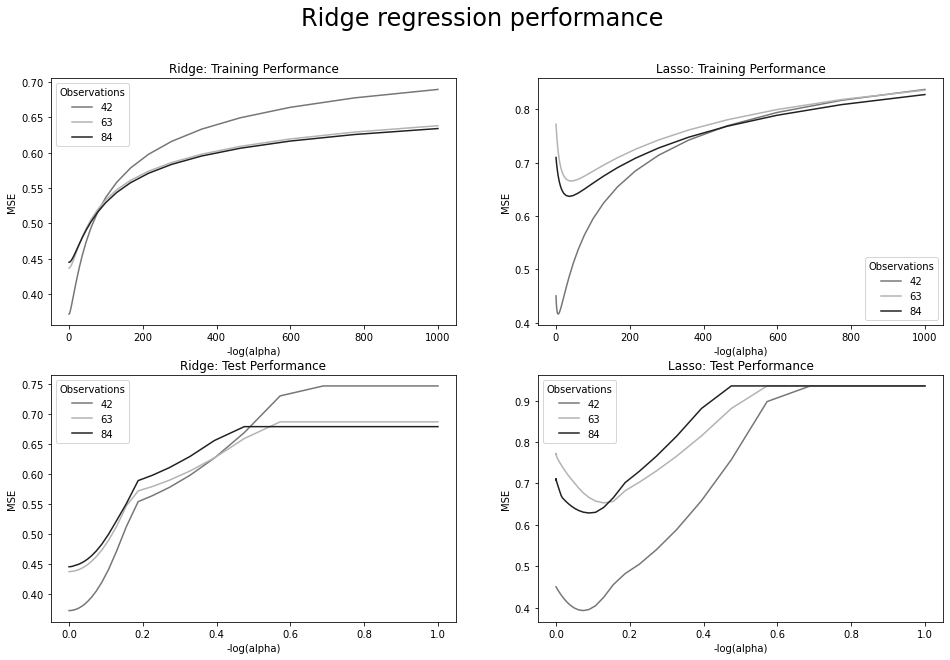

In [29]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

observations = [42, 63, 84]
alpha_list = [np.logspace(-8,3,100), np.logspace(-8,0,100)]
regressions = [Ridge, Lasso]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
row = 0

#--------------------------------------------------------------------------------------------------

for reg in regressions:

    for obv in observations:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = obv
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        sc = StandardScaler(with_std = False)
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        sc = StandardScaler(with_std = False)
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])


        '''    
        print(f'Training set shape: {R_train.shape}')
        print(f'Test set shape: {R_test.shape}')
        '''

        arr_len = len(ind_6)

        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train = np.dot(R_train, eq_w)
        y_test = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train = np.dot(R_train, N)
        X_test = np.dot(R_test, N)

        # Model fitting
        alpha_vec = alpha_list[row]

        train_r2_all = []
        train_mse_all = []
        coeff_dict_all = {}

        test_r2_all = []
        test_mse_all = []

        for cur_alpha in alpha_vec:
            mdl = reg(cur_alpha)
            mdl.fit(X_train, y_train)

            # Training
            train_r2_all.append(mdl.score(X_train, y_train))
            train_mse_all.append(mean_squared_error(y_train, mdl.predict(X_train)))
            coeff_dict_all[cur_alpha] = mdl.coef_

            # Test 
            test_r2_all.append(mdl.score(X_test, y_test))
            test_mse_all.append(mean_squared_error(y_test, mdl.predict(X_test)))

        q3_fig = sns.lineplot(x=alpha_vec, y=np.array(train_mse_all), ax=axs[row,0])
        q3_fig = sns.lineplot(x=alpha_vec, y=np.array(test_mse_all), ax=axs[row,1])
    row += 1

#--------------------------------------------------------------------------------------------------

axs[0,0].title.set_text('Ridge: Training Performance')
axs[1,0].title.set_text('Ridge: Test Performance')
axs[0,1].title.set_text('Lasso: Training Performance')
axs[1,1].title.set_text('Lasso: Test Performance')

axs[0,0].legend(title='Observations', labels=['42', '63', '84'])
axs[1,0].legend(title='Observations', labels=['42', '63', '84'])
axs[0,1].legend(title='Observations', labels=['42', '63', '84'])
axs[1,1].legend(title='Observations', labels=['42', '63', '84'])

axs[0,0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1,0].set(xlabel='-log(alpha)', ylabel='MSE')
axs[0,1].set(xlabel='-log(alpha)', ylabel='MSE')
axs[1,1].set(xlabel='-log(alpha)', ylabel='MSE')


plt.suptitle('Ridge regression performance', fontsize = 24)
plt.show()

### Showing performance of model with deffering observations (Edit)

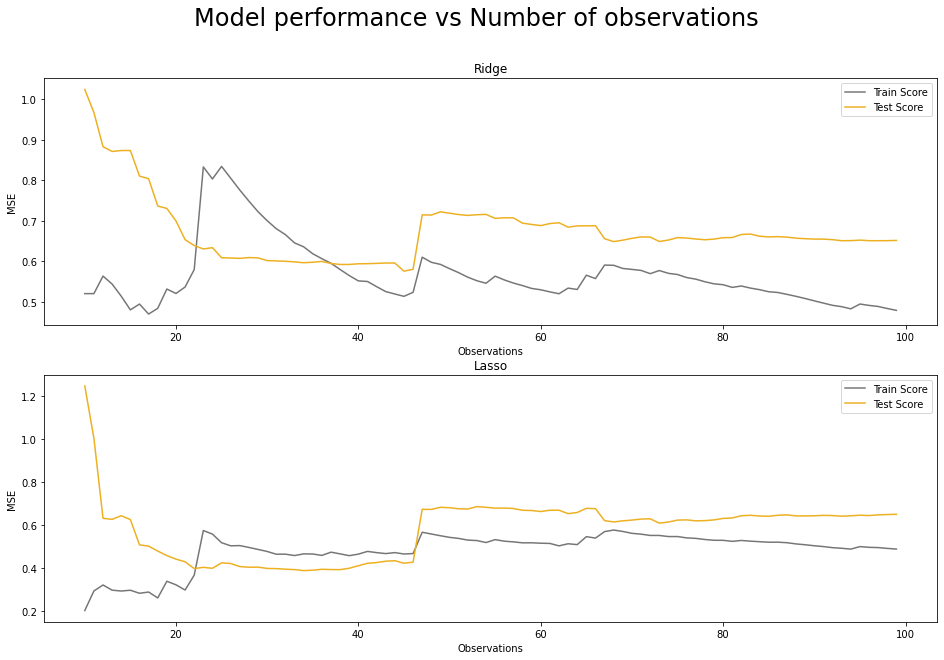

In [30]:
ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

regressions = [Ridge, Lasso]
alpha_list = [100.0, 0.12915496650148853]

observations = list(np.arange(10,100,1))

fig, axs = plt.subplots(nrows=2, figsize=(16,10))

#--------------------------------------------------------------------------------------------------
counter = 0

for reg in regressions:
    train_r2 = []
    train_mse = []
    coeff_dict = {}

    test_r2 = []
    test_mse = []
    
    for obv in observations:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = obv
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        sc = StandardScaler(with_std = False)
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        sc = StandardScaler(with_std = False)
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])

        '''    
        print(f'Training set shape: {R_train.shape}')
        print(f'Test set shape: {R_test.shape}')
        '''

        arr_len = len(ind_6)

        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train = np.dot(R_train, eq_w)
        y_test = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train = np.dot(R_train, N)
        X_test = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------

        regularisation = reg(alpha_list[counter])
        regularisation.fit(X_train, y_train)

        # Training
        train_r2.append(regularisation.score(X_train, y_train))
        train_mse.append(mean_squared_error(y_train, regularisation.predict(X_train)))
        coeff_dict[alpha_list[counter]] = regularisation.coef_

        # Test 
        test_r2.append(regularisation.score(X_test, y_test))
        test_mse.append(mean_squared_error(y_test, regularisation.predict(X_test)))
        
    #------------------------------------------------------------------------------------------------
    # Plotting
    fig = sns.lineplot(y = train_mse, x = observations,
                       label = "Train Score", color='#767676', ax = axs[counter])
    fig = sns.lineplot(y = test_mse, x = observations,
                       label = "Test Score", color='#edb021', ax = axs[counter])
    counter += 1
    
#--------------------------------------------------------------------------------------------------
# Graph
axs[0].title.set_text('Ridge')
axs[1].title.set_text('Lasso')
axs[0].set(xlabel='Observations', ylabel='MSE')
axs[1].set(xlabel='Observations', ylabel='MSE')


plt.suptitle('Model performance vs Number of observations', fontsize = 24)
plt.show()

### GridsearchCV with polynomial features

In [31]:
# Creating the dataset for cross validation 

temp = df.copy()
temp = temp.iloc[:,1: cov_num+1]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = R_train.copy()
R_train = temp.iloc[date_i-63:date_i,:]

# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(no_obj / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = R_test.copy()
R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

#-------------------------------------------------------------------------------------------
# Processing
arr_len = temp.shape[1]

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)
y_temp = np.dot(R_train, eq_w)

# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

# Calculate X
X_temp = np.dot(R_train, N)

#-------------------------------------------------------------------------------------------
temp_df_raw = pd.DataFrame(X_temp)
temp_df_raw.columns = ['X' + str(i) for i in temp_df_raw.columns]
temp_df_raw.insert(1, 'y', y_temp)
temp_df_raw = temp_df_raw.rename({'X0':'x'}, axis=1)

In [32]:
# Essentially this remakes the test set 100 times and gets the mean value of r2 for the 100 different
# samples 

def test(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[X], 
                                                                data[Y], 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)


lasso_params = {'fit__alpha': np.logspace(-8,0,100)}
ridge_params = {'fit__alpha': np.logspace(-8,3,100)}

X = ['x']
X.extend(temp_df.columns[2:])
Y = ['y']

#--------------------------------------------------------------------------------------------------

pipe1 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', LinearRegression())])
pipe2 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Lasso(tol=1e-2))])
pipe3 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Ridge())])

models3 = {'OLS': pipe1,
           'Lasso': GridSearchCV(pipe2, 
                                 param_grid=lasso_params).fit(temp_df[X], temp_df[Y]).best_estimator_ ,
           'Ridge': GridSearchCV(pipe3, 
                                 param_grid=ridge_params).fit(temp_df[X], temp_df[Y]).best_estimator_,}

#--------------------------------------------------------------------------------------------------


test(models3, temp_df_raw)

,OLS,Lasso,Ridge
0,1.00000,0.019908,0.815841
1,-0.88843,-0.145103,-0.494836


### Fitting with polynomial features 

The primary assumption of Polynomial Regression is that there might exist a non-linear relationship between the features (independent variables) and the target (dependent variable). It is also used when the linear model is unable to capture the trend in the data and gives a poor R² score. In this case, Polynomial Regression increases the model complexity by adding “new” features from existing ones using their higher powers and combinations.


Polynomial Regression exposes the interactions between the features and target and interactions among the features, if any. Linear models such as Linear Regression and Logistic Regression can be made much more powerful and complex using Polynomial Regression.


One downside of Polynomial Regression is that it requires a lot of experimenting with its parameters as there is no hard and fast rule associated with it.

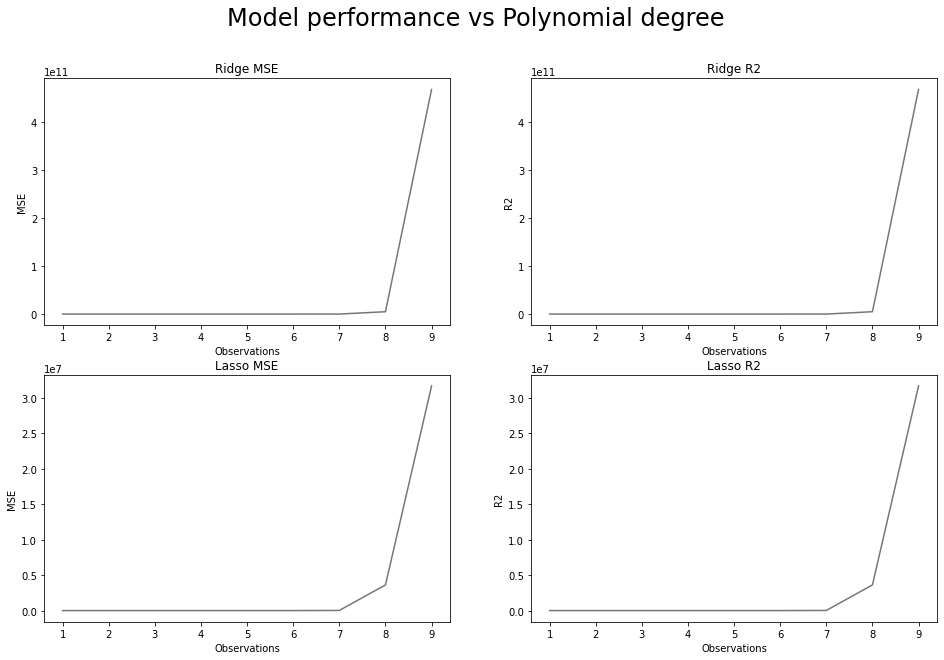

In [33]:

pipe2 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Lasso(alpha_list[1], tol=1e-2))])
pipe3 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Ridge(alpha_list[0]))])

#--------------------------------------------------------------------------------------------------

ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

regressions = [Ridge, Lasso]
alpha_list = [100.0, 0.12915496650148853]

poly_list = list(np.arange(1,10,1))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

counter = 0

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    train_mse = []
    train_r2 = []
    
    test_r2 = []
    test_mse = []
    
    for poly in poly_list:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = obv
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])


        arr_len = len(ind_6)
        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)
        y_test_raw = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        X_test_raw = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------------
        
        model = Pipeline([("scaler", StandardScaler(with_std = False)),
                          ('poly', PolynomialFeatures(degree = poly, )),
                          ('fit', reg(alpha_list[0]))])
        
        score_mse = cross_val_score(estimator = model , X = X_train_raw, y = y_train_raw, cv = 5,
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)
        train_mse.append(abs(score_mse.mean()))
        
        score_r2 = cross_val_score(estimator = model, X = X_train_raw, y = y_train_raw, cv = 5,
                                 scoring = 'r2', n_jobs = -1)
        train_r2.append(abs(score_r2.mean()))
        
    #------------------------------------------------------------------------------------------------
    # Plotting
    fig = sns.lineplot(y = train_r2, x = poly_list, color='#767676', ax = axs[counter,0])
    
    fig = sns.lineplot(y = train_r2, x = poly_list, color='#767676', ax = axs[counter,1])
    
    counter += 1
    
#--------------------------------------------------------------------------------------------------
# Graph
axs[0,0].title.set_text('Ridge MSE')
axs[1,0].title.set_text('Lasso MSE')
axs[0,1].title.set_text('Ridge R2')
axs[1,1].title.set_text('Lasso R2')
axs[0,0].set(xlabel='Observations', ylabel='MSE')
axs[0,1].set(xlabel='Observations', ylabel='R2')
axs[1,0].set(xlabel='Observations', ylabel='MSE')
axs[1,1].set(xlabel='Observations', ylabel='R2')


plt.suptitle('Model performance vs Polynomial degree', fontsize = 24)
plt.show()

### Visualisation of overfitting for polynomial

C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.67265e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
C:\Users\seanl\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e+01, tolerance: 4.330e-03
  model = cd_fast.enet_coordinate_descent(


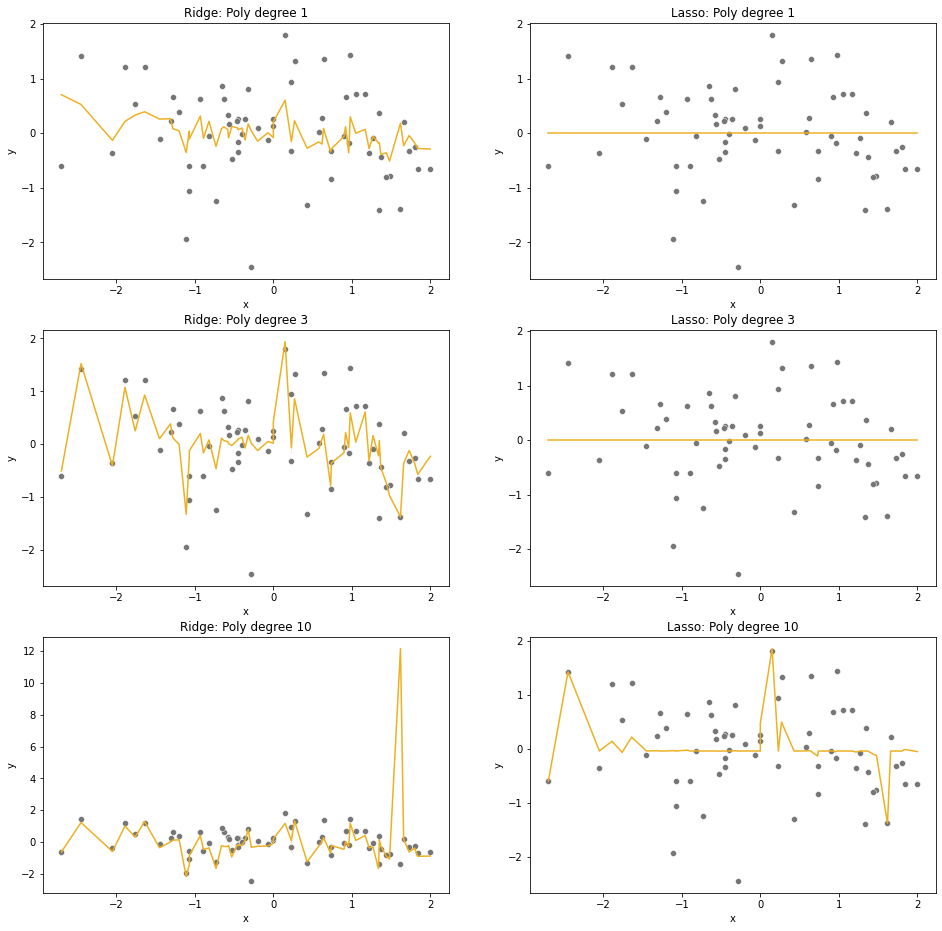

In [34]:

pipe2 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Lasso(alpha_list[1], tol=1e-2))])
pipe3 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Ridge(alpha_list[0]))])

#--------------------------------------------------------------------------------------------------

ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

regressions = [Ridge, Lasso]
alpha_list = [100.0, 0.12915496650148853]

poly_list = [1,3,10]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

col = 0

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    train_mse = []
    train_r2 = []
    
    test_r2 = []
    test_mse = []
    row = 0
    
    for poly in poly_list:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = 63
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])

        arr_len = len(ind_6)
        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)
        y_test_raw = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        X_test_raw = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------------
        
        model = Pipeline([("scaler", StandardScaler(with_std = False)),
                          ('poly', PolynomialFeatures(degree = poly, )),
                          ('fit', reg(alpha_list[0]))])
        
        temp_df = pd.DataFrame(X_train_raw)
        temp_df.columns = ['X' + str(i) for i in temp_df.columns]
        temp_df.insert(1, 'y', y_train_raw)
        temp_df = temp_df.rename({'X0':'x'}, axis=1)
        
        features = temp_df.drop('y', axis = 1)
        target = temp_df['y']
        preds = model.fit(features, target).predict(features)
        sns.scatterplot(x = temp_df.x, y = temp_df.y, color='#767676', ax = axs[row,col])
        sns.lineplot(x = temp_df.x, y = preds, color='#edb021', ax = axs[row,col])
        row += 1
        
    col += 1


#--------------------------------------------------------------------------------------------------
# Graph

axs[0,0].title.set_text('Ridge: Poly degree 1')
axs[1,0].title.set_text('Ridge: Poly degree 3')
axs[2,0].title.set_text('Ridge: Poly degree 10')
axs[0,1].title.set_text('Lasso: Poly degree 1')
axs[1,1].title.set_text('Lasso: Poly degree 3')
axs[2,1].title.set_text('Lasso: Poly degree 10')
        
        

### Polynomial with changing the number of observations

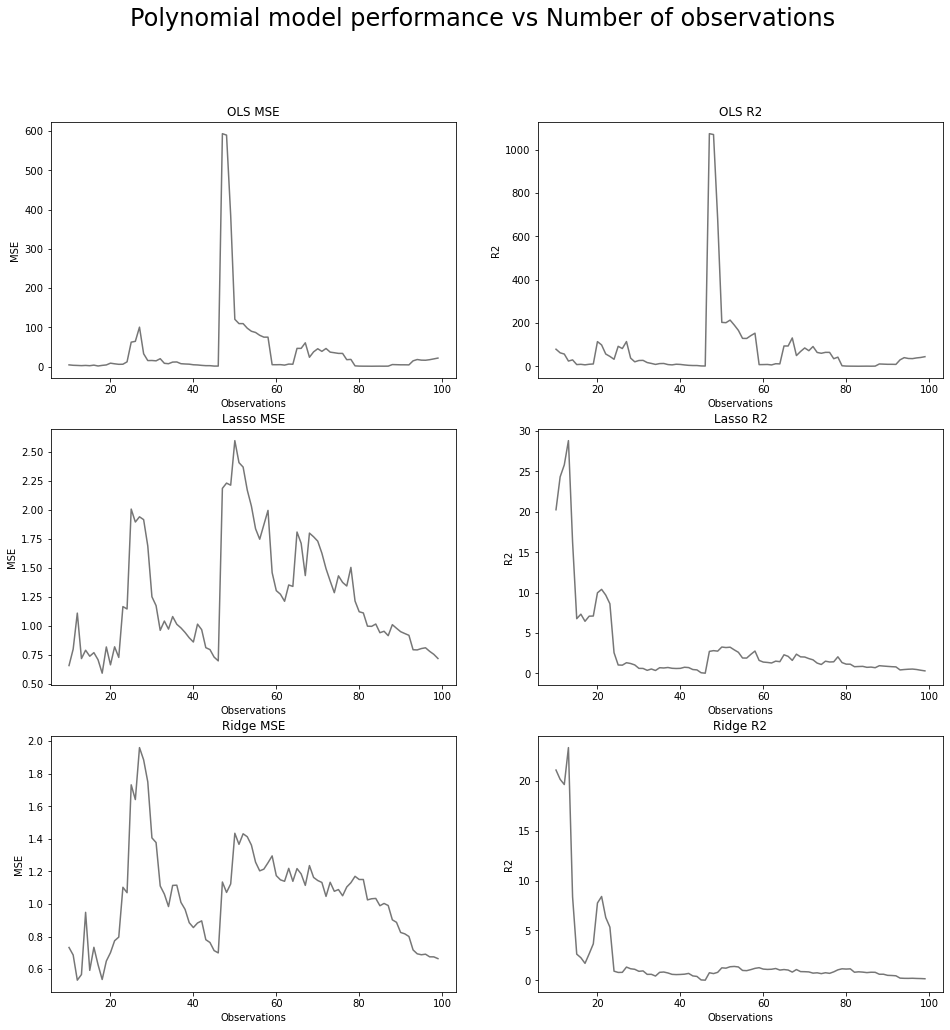

In [35]:
pipe1 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', LinearRegression())])
pipe2 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Lasso(alpha_list[1], tol=1e-2))])
pipe3 = Pipeline([("scaler", StandardScaler(with_std = False)),
                  ('poly', PolynomialFeatures()),
                  ('fit', Ridge(alpha_list[0]))])

models = {'OLS': pipe1,
          'Lasso': pipe2,
          'Ridge': pipe3
         }



#--------------------------------------------------------------------------------------------------

ind_6 = ['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']
ind_24 = ['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']
ind_48 = list(df.columns)[1:]

regressions = [Ridge, Lasso]
alpha_list = [100.0, 0.12915496650148853]

observations = list(np.arange(10,100,1))

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

counter = 0

#--------------------------------------------------------------------------------------------------

for i in models:
    train_mse = []
    train_r2 = []
    
    for obv in observations:
        q3_temp = df.copy()
        q3_temp = q3_temp[ind_6]

        # Selecting training set
        date = '2022-01-03'
        no_obj = obv
        date_i = df[df['Date'] == date].index[0]

        R_train = q3_temp.iloc[date_i-no_obj:date_i,:]

        R_train = R_train.copy()
        R_train.loc[:,R_train.columns] = sc.fit_transform(R_train.loc[:,R_train.columns])


        # Selecting the test set (dates after the 1 day in 2022)
        date = '2022-01-03'
        no_obj = int(63 / .7 * .3)
        date_i = df[df['Date'] == date].index[0]

        R_test = q3_temp.iloc[date_i:date_i+no_obj,:]

        R_test = R_test.copy()
        R_test.loc[:,R_test.columns] = sc.fit_transform(R_test.loc[:,R_test.columns])


        arr_len = len(ind_6)
        # y values
        eq_w = np.full(
            shape = arr_len,
            fill_value = 1/arr_len
        )

        y_train_raw = np.dot(R_train, eq_w)
        y_test_raw = np.dot(R_test, eq_w)


        # X values
        tmp1 = np.identity((arr_len-1), dtype='int64')
        tmp2 = -np.ones((arr_len-1), dtype='int64')
        N = np.append(tmp1,[tmp2], axis=0)

        X_train_raw = np.dot(R_train, N)
        X_test_raw = np.dot(R_test, N)
        
        #--------------------------------------------------------------------------------------------------

        
        scores = cross_val_score(estimator = models[i], X = X_train_raw, y = y_train_raw, cv = 5,
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)
        train_mse.append(abs(scores.mean()))
        
        score_r2 = cross_val_score(estimator = models[i], X = X_train_raw, y = y_train_raw, cv = 5,
                                 scoring = 'r2', n_jobs = -1)
        train_r2.append(abs(score_r2.mean()))

        #------------------------------------------------------------------------------------------------
    # Plotting
    fig = sns.lineplot(y = train_mse, x = observations, color='#767676', ax = axs[counter,0])
    
    fig = sns.lineplot(y = train_r2, x = observations, color='#767676', ax = axs[counter,1])
    counter += 1
    
#--------------------------------------------------------------------------------------------------
# Graph
axs[0,0].title.set_text('OLS MSE')
axs[1,0].title.set_text('Lasso MSE')
axs[2,0].title.set_text('Ridge MSE')
axs[0,1].title.set_text('OLS R2')
axs[1,1].title.set_text('Lasso R2')
axs[2,1].title.set_text('Ridge R2')

axs[0,0].set(xlabel='Observations', ylabel='MSE')
axs[1,0].set(xlabel='Observations', ylabel='MSE')
axs[2,0].set(xlabel='Observations', ylabel='MSE')
axs[0,1].set(xlabel='Observations', ylabel='R2')
axs[1,1].set(xlabel='Observations', ylabel='R2')
axs[2,1].set(xlabel='Observations', ylabel='R2')


plt.suptitle('Polynomial model performance vs Number of observations', fontsize = 24)
plt.show()


### Sum of absolute deviations 

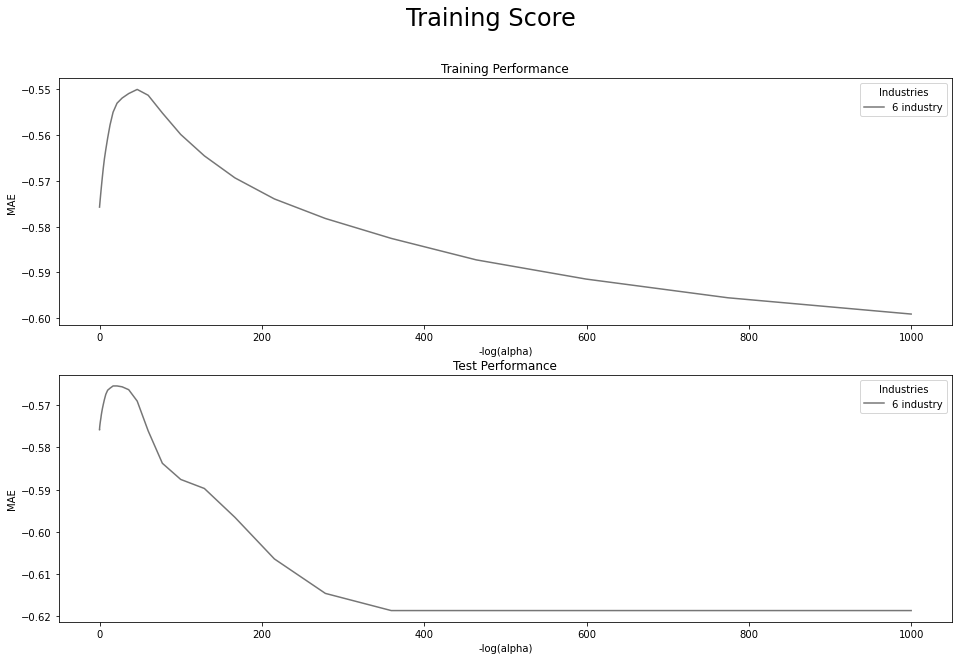

In [36]:
alpha_vec = np.logspace(-8,3,100)

regressions = [Ridge, Lasso]
fig, axs = plt.subplots(nrows=2, figsize=(16,10))

alpha_list = [np.logspace(-8,3,100), np.logspace(-8,0,100)]

counter = 0 

#--------------------------------------------------------------------------------------------------

for reg in regressions:
    cvResults = []
    
    for cur_alpha in alpha_list[counter]:

        clf_cv = Pipeline(steps=[("scaler", StandardScaler(with_std = False)),
                                 ("mdl", reg(cur_alpha))])

        # Perform 10-fold cross validation 
        scores = cross_val_score(estimator = clf_cv, X = X_train_raw, y = y_train_raw, cv = 8, \
                                 scoring = 'neg_mean_absolute_error', n_jobs = -1)

        cvResults.append(scores.mean())
        
    fig = sns.lineplot(y = cvResults, x = alpha_vec, label = "Train Score", ax = axs[counter])
        
    counter += 1

#--------------------------------------------------------------------------------------------------

# Graph
axs[0].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[0].title.set_text('Training Performance')
axs[1].legend(title='Industries', labels=['6 industry', '24 industry', '48 industry'])
axs[1].title.set_text('Test Performance')

axs[0].set(xlabel='-log(alpha)', ylabel='MAE')
axs[1].set(xlabel='-log(alpha)', ylabel='MAE')

plt.suptitle('Training Score', fontsize = 24)
plt.show()